# 1. Author

**Student Name**:  BINEETA KACHHAP

**Student ID**:  210619025



# 2. Problem formulation

**Advanced solution**

A Machine Learning model would be build to predict which two songs are difficult to predict or a pair of class is confused the most among each other. The model will classify all the 8 songs and a confusion matrix would be constructed to analyse the Precision, Recall and accuracy for each of the class.

# 3. Machine Learning pipeline

For the basic solution of classification, following stages and methods have been implemented to build a model. 

1. **Data Load**: Loading the .wav files from the link provided in the MLEnd Hums and Whistles.
2. **Identify Label**: All the files from the drive where read and anlaysed to identify the label classification.
3. **Feature Extraction**: The .wav files were read and multiple features like MFCC, STFT, Spectral Centroids, Roll-Off, Spectral Flux, Chromagram for each note was extracted.  
4. **Component Analysis**: after feature extraction, Principle compoenet analysis was performed to understand the standout features that woudl assist in classification.
5. **Modelling with Pipeline**: The machine learning model where implemented. The pipeline for the ML includes 
> * Standard Scaler: The training data is normalised with mean μ and standard deviation σ
> * Feature Selection: SelectkBest()
> * Classifier Model 
6. **Model/Training Analysis**: The model training accuracy for each test was analysedusing the cross_val_score. The method of confusion matrix has been used to calculate the Precision, Recall accuracy for each of the class and analyse further the training and validation accuracy. 
7. **Validation/Test Analysis**: The validation accuracy was calculated and the method of confusion matrix has been used to calculate the Precision, Recall accuracy for each of the class for the validation.


The code cell has been partitioned into section and below is the brief description of each section. The stages have been deatiled out as we further go down the project.

---
**Code Section - A** : Importing all the libraries

In [73]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display
import sklearn

import seaborn as sns
from scipy import stats
from sklearn import svm
import seaborn as snsDistance

from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.manifold import MDS
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

**Code Section - B** : Mount Google Drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

**Code Section - C** : The below set of code has been re-used form starters kit was required to be executed ones to load the data and unzip and the data to the google drive mount location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())


In [ ]:
# Example for one of the song
potter_url  = "https://collect.qmul.ac.uk/down?t=6122TDAA73VPCMDQ/5DSHD27BLQMK5S8E1HLG19O"
save_path = '/content/drive/MyDrive/Data/MLEndHW/Potter_1.zip'
download_url(potter_url, save_path)

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndHW/miniProjectAdv/'
zip_path = '/content/drive/MyDrive/Data/MLEndHW/Potter_1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# 4. Transformation stage

Describe any transformations, such as feature extraction. Identify input and output.

**Code Section - D : Identify Labels**

The below set of code in Section has been implemented to;
* loads the individual files from the drive location. Function getDriveFiles() return all the list of files for the analysis.
* The list of files are iterated and each filename is applied lowercase, splits, stores individual values in array **splitFileName**
* **splitFileName** is passed to an utility function **validateFileName** which validates the names rectifies any human error input and return an correct version of the name. **errorLists_Dict** is created with set of error filenames.
* **Label_Error_Analysis.txt** file is generated to check if there was any error in the naming convention and **errorLists_Dict** was updated with releveant new errorlist.
* The updated corrected version of the file names are then loaded into MLENDHW_df dataframe and saved into **MLENDHW_Label_basic.csv** for further use.
* The below set of code needs to be executed ones. for further execution **MLENDHW_Label_basic.csv** can be loaded.


E.g.: Example of **Label_Error_Analysis.txt** of error. for the below Error 'Imperial' was added in **errorLists_Dict**

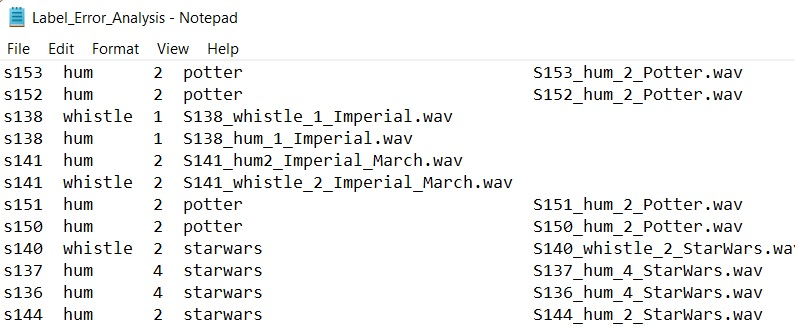

In [ ]:
errorLists_Dict = {'starwars': ['starwars', 'starwar','star', 'war', 'stars', 'imperial'],
                   'showman': ['showman', 'this','snowman'],
                   'rain': ['rain', 'sing'],
                   'potter': ['harry', 'potter'],
                   'panther': ['panther', 'pink','pinkpanther','panter'],
                   'mamma': ['mamma','mia','mama','mumma'],
                   'hakuna': ['hakuna','matata','haknua','hukuna','hakana'],
                   'frozen': ['frozen','let','it','go']}

# utility function to validate the filename and return the appropriate class labels
def validateFileName(splitFileName):

  newSplitFileName = []
  id = splitFileName[0]
  newSplitFileName.append(id)

  splitFileName.remove(id)

  result = any(elem.find('hum') > -1 for elem in splitFileName)   
  if result:
    newSplitFileName.append('hum')
  else :
    newSplitFileName.append('whistle')

  for i in range(1,5,1):
    result = any(elem.find(str(i)) > -1 for elem in splitFileName)
    if result:
      newSplitFileName.append(str(i))

  for key in errorLists_Dict:
    errorList = errorLists_Dict[key]
    for errorWord in errorList:
      result = any(elem.find(errorWord) >-1  for elem in splitFileName)
      if result:
        newSplitFileName.append(key)
        break

  #newSplitFileName = ['s108_whistle_1_singingintherain.wav','s108', 'whistle', '1', 'rain'])
  return newSplitFileName


In [ ]:
# utility function to retrieve file from the location
def getDriveFiles():
  drive.mount('/content/drive')
  path = '/content/drive/MyDrive/Data/MLEndHW'
  os.listdir(path)
  filePath = '/content/drive/MyDrive/Data/MLEndHW/miniProjectAdv/*'
  files = glob.glob(filePath)
  print(len(files))
  return files


In [ ]:
import re
MLENDHW_table = [] 
files = getDriveFiles()
for file in files:
  fileName = file.split('/')[-1]
  temp_fileName = fileName.lower()
  temp_fileName = temp_fileName.replace(' ', '')
  splitFileName = re.split('_|\.',temp_fileName)
  splitFileName = validateFileName(splitFileName)
  splitFileName.append(fileName)
  MLENDHW_table.append(splitFileName) 

from tabulate import tabulate
with open('Label_Error_Analysis.txt', 'w') as outputfile:
    outputfile.write(tabulate(MLENDHW_table))

Mounted at /content/drive
3330


In [ ]:
MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['participant','interpretation','number','song','file_id']).set_index('file_id') 
MLENDHW_df
MLENDHW_df.to_csv('MLENDHW_Label_adv.csv')

In [ ]:
MLENDHW_df = pd.read_csv('MLENDHW_Label_adv.csv')
MLENDHW_df.head()

,file_id,participant,interpretation,number,song
0,S137_hum_4_Rain.wav,s137,hum,4,rain
1,S42_Hum2_The Rain.wav.wav,s42,hum,2,rain
2,S219_hum_2_Panther.wav,s219,hum,2,panther
3,S80_whistle_2_Potter.wav,s80,whistle,2,potter
4,S218_whistle_1_Panther.wav,s218,whistle,1,panther




---


**Code Section - E : Feature Extraction**

The below set of code extracts numerical information from the .wav 
* Features like MFCC, STFT, Spectral Centroids, Roll-Off, Spectral Flux, Chromagram for each note was extracted. **getFeatures** method is used wher the list of .wav files are passed and it return.
>* **X_data** with features extracted for each song in array form the. The array if os shape (Number of song,  Number of feature)
>* **y_data** : class label for each of the son fetched from the MLENDHW_df dataframe.
>* **fileId** : list of filenames.

* The extracted features are then loaded into dataframe and saved into **MLEndHW_mini_AdvData.csv** for further use.
* The below set of code needs to be executed ones. for further execution **MLEndHW_mini_AdvData.csv** can be loaded.
* LabelEncoder is used to re-label the songname to a numerical value and is saved in the column **Target**. the updated data is then saved into **MLEndHW_mini_AdvDataLabelled.csv**
* From the csv, the data is saved into dataframe **df** or as numpy array **X_all, y_all** based on usage.
* For this classification problem all the labels are collected as it is and saved under the column 'class'. 

In [ ]:
def getMeanStd(feature):
  featureMean = np.nanmean(feature) if np.mean(np.isnan(feature))<1 else 0
  featureStd = np.nanstd(feature) if np.mean(np.isnan(feature))<1 else 0
  return featureMean, featureStd

In [ ]:
#utility funtion to fetch all the related feature for a .wav
def getFeatures(files,labels_file,scale_audio=False):
  
  X,y,fileID =[],[],[]
  winLen=0.02
 
  for file in tqdm(files):
    file_ID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[file_ID]['song']

    fs = None # Sampling frequency. If None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    
    power = np.sum(x**2)/len(x)
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,frame_length=frame_length,hop_length=hop_length)
    stft = np.abs(librosa.stft(x))
    mfcc = librosa.feature.mfcc(y=x, sr=fs)
    amplitude = librosa.amplitude_to_db(x)
    zRate = librosa.feature.zero_crossing_rate(x)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=fs)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=fs)[0]
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=fs)[0]
    spectralFlux = librosa.onset.onset_strength(y=x, sr=fs)

    voiced_fr = np.mean(voiced_flag)
    voiced_pr = np.mean(voiced_probs)
    pitch_mean, pitch_std = getMeanStd(f0)
    stft_mean,stft_std = getMeanStd(stft)
    mfcc_mean,mfcc_std = getMeanStd(mfcc)
    flux_mean,flux_std = getMeanStd(spectralFlux)
    amp_mean,amp_std = getMeanStd(amplitude)
    zRate_mean,zRate_std = getMeanStd(zRate)
    centroid_mean,centroid_std = getMeanStd(spectral_centroids)
    rolloff_mean,rolloff_std = getMeanStd(spectral_rolloff)
    bandwidth_mean,bandwidth_std = getMeanStd(spectral_bandwidth_2)
    

    xi = [power, pitch_mean, pitch_std,voiced_fr, voiced_pr,
          stft_mean, stft_std, mfcc_mean, mfcc_std,flux_mean,flux_std,amp_mean,amp_std,zRate_mean,zRate_std,
          centroid_mean, centroid_std, rolloff_mean, rolloff_std, bandwidth_mean, bandwidth_std]
    chromagram = librosa.feature.chroma_stft(y=x, sr=fs)
    for row in chromagram:
      node_mean, node_std = getMeanStd(row)
      xi.append(node_mean)
      xi.append(node_std)
    X.append(xi)
    y.append(yi)
    fileID.append(file_ID)
  return np.array(X),np.array(y),np.array(fileID)


In [ ]:
X_Data,y_Data,fileIds = getFeatures(files, labels_file=MLENDHW_df,scale_audio=True)

100%|██████████| 3330/3330 [3:42:21<00:00,  4.01s/it]


In [ ]:
df = pd.DataFrame(data=X_Data, columns=['power','pitch_mean', 'pitch_std','voiced_fr', 'voiced_pr',
          'stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std','amp_mean','amp_std','zRate_mean','zRate_std',
          'centroid_mean', 'centroid_std', 'rolloff_mean', 'rolloff_std', 'bandwidth_mean', 'bandwidth_std',
          'C_mean', 'C_std', 'C#_mean', 'C#_std', 'D_mean', 'D_std', 'D#_mean', 'D#_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
          'F#_mean', 'F#_std', 'G_mean', 'G_std', 'G#_mean', 'G#_std', 'A_mean', 'A_std', 'A#_mean', 'A#_std', 'B_mean', 'B_std'])
df['class'] = y_Data
df['fileIds'] = fileIds
df.to_csv('MLEndHW_mini_AdvData.csv')

In [ ]:
df = pd.read_csv('MLEndHW_mini_AdvData.csv')
df = df.iloc[: , 1:]
ord_enc = LabelEncoder() # applying Label Encoder to changes the song name to numerical value.
df["Target"] = ord_enc.fit_transform(df["class"])
print('Label Order from 0 to 7: ',ord_enc.inverse_transform(range(0,8,1)))
df.to_csv('MLEndHW_mini_AdvDataLabelled.csv')

Label Order from 0 to 7:  ['frozen' 'hakuna' 'mamma' 'panther' 'potter' 'rain' 'showman' 'starwars']


In [68]:
df = pd.read_csv('MLEndHW_mini_AdvDataLabelled.csv')
df = df.iloc[: , 1:]
print(df.head())

      power  pitch_mean  pitch_std  ...    class                     fileIds  Target
0  0.010301  227.652625  56.676628  ...     rain         S137_hum_4_Rain.wav       5
1  0.018948  314.642587  64.515629  ...     rain   S42_Hum2_The Rain.wav.wav       5
2  0.000908  281.640580  50.608643  ...  panther      S219_hum_2_Panther.wav       3
3  0.001049  397.934654  49.397803  ...   potter    S80_whistle_2_Potter.wav       4
4  0.146069  399.828100  33.606313  ...  panther  S218_whistle_1_Panther.wav       3

[5 rows x 48 columns]


**Code Section - F** : Feature Analysis / Importance 

Visualization have been used to analyse the relation between the feature and songs.

In [ ]:
y_all = df['Target']
X_all = df[['stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std',
                'C_mean', 'C_std', 'D_mean', 'D_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
                'G_mean', 'G_std', 'A_mean', 'A_std', 'B_mean', 'B_std'
           ]].to_numpy()

In [ ]:
df_analysis_all = df.drop(['class','fileIds','Target'], axis=1)
df_analysis_some = df[['stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std',
                'C_mean', 'C_std', 'D_mean', 'D_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
                'G_mean', 'G_std', 'A_mean', 'A_std', 'B_mean', 'B_std'
                ]]

* **PCA** : Principle Component analysis was implemented to reduce the dimension and get an overview of the chosen feature. As PCA estimated the eucledian distance between the feature to reduce the numerosity on feature, this method can be used for component analysis. For this project the PCA was not that helpful with the datasize of 3330 rows.
* **df_analysis_all**: contains all the feature.
* **df_analysis_some**: contains some selected feature.



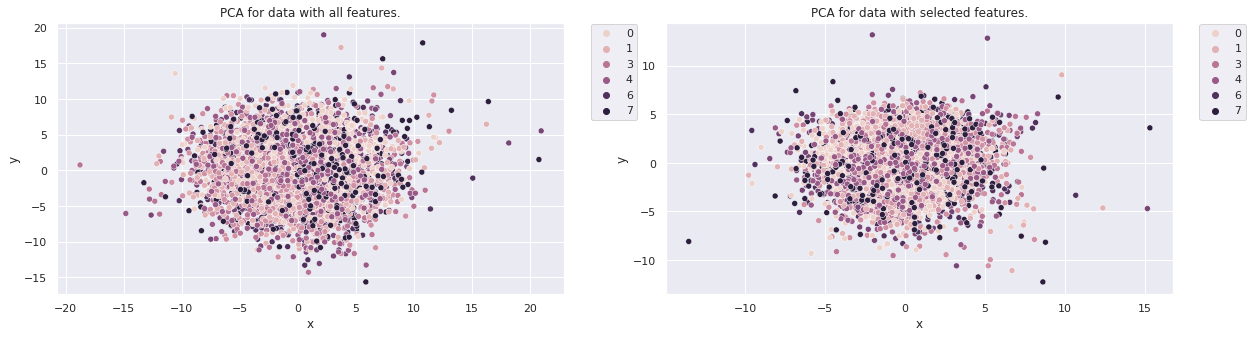

In [ ]:
# Plot 3D scatterplot of outlier scores
fig = plt.figure(figsize=(20,5))

#PCA for data with all features
standardisedDF = df_analysis_all.apply(stats.zscore)
embedding = MDS(n_components=2)
Xp = embedding.fit_transform(standardisedDF)
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1]})
df_projection['Class'] = y_all
## Scatter plot for df_analysis_all
ax = fig.add_subplot(121)
sns.scatterplot(x='x', y='y', hue='Class', data=df_projection)
plt.title('PCA for data with all features.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

#PCA for data with selected features
standardisedDF = df_analysis_some.apply(stats.zscore)
embedding = MDS(n_components=2)
Xp = embedding.fit_transform(standardisedDF)
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1]})
df_projection['Class'] = y_all
## Scatter plot for df_analysis_some
ax = fig.add_subplot(122)
sns.scatterplot(x='x', y='y', hue='Class', data=df_projection)
plt.title('PCA for data with selected features.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

* **Distance Matrix**: The data is sorted w.r.t label/target column.The distance between two songs is coloured according to the euclidian distance between the pair of feature of the two song, this visualization is not so helpful in analysis. For e.g. in x-axis and y axis, marked from 0-204 can be considered the data from label-0/frozen, the section of data has mixture of color depth and is not helpful in understanding the similarity between the song of same label. 

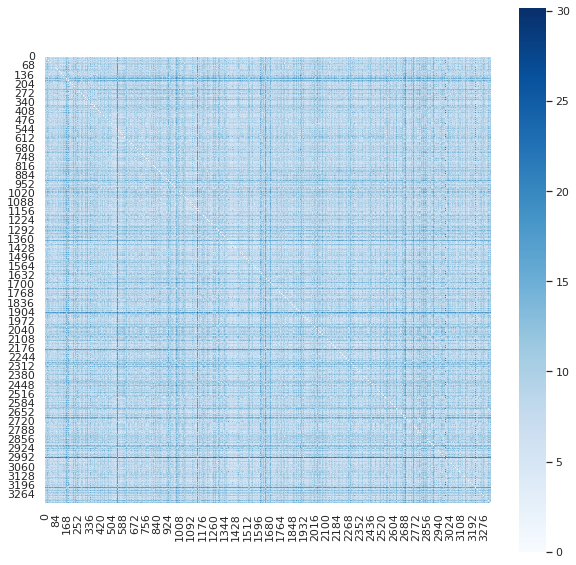

In [ ]:
df_sorted = df.sort_values(by='class', ascending=True)

X1 = df_sorted.drop(['fileIds','class','Target'], axis=1).to_numpy()
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
# calculate the distance between song based on feature
dist = distance.squareform(distance.pdist(X1))
snsDistance.set(rc={'figure.figsize':(10,10)})
snsDistance.heatmap(dist, square=True, cmap='Blues')
plt.show()

* **Spearman’s correlation matrix**: From the correlation matrix, the correlation between the feature are derived. This step is helpful in finding the highly correlated attribute/feature and can be dropped for further analysis so as to remove the rededundancy.

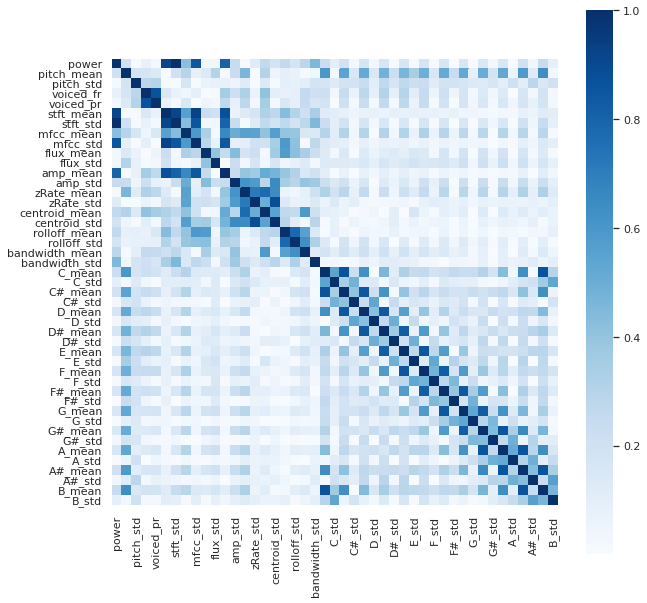

Column that can be dropped: ['voiced_pr', 'stft_mean', 'stft_std', 'mfcc_std', 'amp_mean', 'centroid_std', 'C#_mean', 'D_mean', 'D#_mean', 'E_mean', 'F_mean', 'F#_mean', 'G_mean', 'G#_mean', 'A_mean', 'A#_mean', 'B_mean']


In [ ]:
X1 = df.drop(['fileIds','class','Target'], axis=1)
corrMatrix = X1.corr(method = "spearman").abs()

# Spearman’s correlation matrix heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrMatrix, cmap= "Blues", square=True, ax = ax)
plt.show()

# Select higher Value from the matrix
highValue = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in highValue.columns if any(highValue[column] > 0.8)]
print('Column that can be dropped:',to_drop)
# Drop features
X_all = X1.drop(to_drop, axis = 1)

# 5. Modelling

For this basic solution to classify between HarryPotter and Starwars: two models have been implemented and validation is carried out with the test data. SVC and KNN were chosen as proximity of the individual features had to be calculated to understand and classify the two sets of data.

* **Nu-Support Vector Classification**:  SVC has been used as one of the model, where the regularization parameter was set to nu=[0.1, 0.5, 0.9]. The nu parameter is the upper parameter set for misclassification while the training the model. 
 
* **KNeighbour Classifier**: the KNN model has ben used with n_neighbors=[50, 75, 100]. As 70% of the data (2000+) is used for training the data, so about 250 data would be present for each class while training the module.

* **Random Forest Classifier**: Random Forest Classifier has been used as one of the model, where the regularization parameter was set to n_estimators=[4,8].

* **GradientBoosting Classifier**: The gradient booting classifier has ben used with learning_rate= [0.1, 0.25, 0.5, 1] and n_estimators= [8]

* **Extra Trees Classifier**:The Extra tree Classifier was tried out eith n_estimators= [10,20].

* **Extra Trees Classifier**:The Extra tree Classifier was tried out eith n_estimators= [10,20].


# 6. Methodology

Following methodology has ben used to build the model.
* **train_test_split**: Data are split into **70% training data and 30% Validation data** set as we can see in code Section G. 70% Training data is used to build the model.
* **Standard Scaler**: transformation has been used to normalised the feature. 
* **Feature selection**: As there are about 40+ featured extracted from the ,wav data. SelectkBest() method has been used to select the best features for the model. The feature selection was set with data from k=[7, 14, 21, 28].
* **RepeatedStratifiedKFold**: repeated Cross validation method has been used to internally validated. With parameters as **n_splits=10**, the 70% of training data is internally split into 10 parts and cross validator repeates the test **n_repeats=10** times with randomized set. 10*10 set of data are being fit by the model and evaluated.
* **GridSearchCV**: Grid Search Cross validation is used to validate with various parameter set for individual model. The param_grid is set with various range of parameter to select the best parameter to build the model. 
* **Confusion Matrix**: is used to analyse the Precision, recall and accuracy for each class after the model is build. utility function **predictScoreAndPlot** is implemented to build the matrix. The utlity is implemented to validate both Training and Validation Data.



**Code Section - G** : Data-Set Split 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.3, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2331, 28), (999, 28), (2331,), (999,))

# 7. Dataset


The Preprocessing of the data/feature selection and deatiled description has been done in the Code Section - F.

Following steps have been included in the pipeline as part of pre-processing the data.
* **train_test_split**: Data are split into **70% training data and 30% Validation data** set as we can see in code Section G. 70% Training data is used to build the model.
* **Standard Scaler**: transformation has been used to normalised the feature. 
* **Feature selection**: As there are about 40+ featured extracted from the signla data. SelectkBest() method has been used to select the best features for the model.



In [ ]:
X_all

,power,pitch_mean,pitch_std,voiced_fr,mfcc_mean,flux_mean,flux_std,amp_std,zRate_mean,zRate_std,centroid_mean,rolloff_mean,rolloff_std,bandwidth_mean,bandwidth_std,C_mean,C_std,C#_std,D_std,D#_std,E_std,F_std,F#_std,G_std,G#_std,A_std,A#_std,B_std
0,0.010301,227.652625,56.676628,0.797170,-11.364123,1.241409,1.025740,15.751266,0.025439,0.017357,1692.256931,2220.967073,1989.480555,2746.928977,989.627923,0.281458,0.325760,0.318071,0.374363,0.302358,0.326609,0.348653,0.332676,0.393218,0.329101,0.313810,0.325387,0.326446
1,0.018948,314.642587,64.515629,0.822518,-22.128174,0.649015,0.524022,19.614880,0.054315,0.117773,1779.090778,1120.029610,740.386370,1835.933400,858.240131,0.313900,0.381369,0.362978,0.354098,0.420168,0.333863,0.284438,0.321653,0.250810,0.219026,0.229719,0.341082,0.297429
2,0.000908,281.640580,50.608643,0.382057,-29.617590,0.499661,0.805221,25.854362,0.312136,0.299201,7206.002061,698.038831,928.386756,2990.765756,943.978549,0.542750,0.308332,0.290283,0.322248,0.354124,0.373345,0.282887,0.263047,0.255939,0.245880,0.249391,0.262558,0.363921
3,0.001049,397.934654,49.397803,0.674091,-24.444288,0.984622,0.661063,18.416113,0.107167,0.078744,3369.271693,2049.059325,1472.549585,3147.561993,835.997235,0.197443,0.313896,0.266574,0.279082,0.293492,0.351815,0.353610,0.336178,0.372023,0.321810,0.394491,0.352540,0.360062
4,0.146069,399.828100,33.606313,0.584095,-14.144649,1.339746,1.147998,23.936764,0.151093,0.159179,3970.382724,5851.870687,3352.492065,4043.645736,1222.688506,0.286558,0.345307,0.369050,0.348551,0.342737,0.360112,0.296878,0.272048,0.281759,0.297099,0.312907,0.329192,0.340041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,0.002503,411.702364,36.733243,0.688658,-27.074667,0.744910,0.674132,21.149096,0.114378,0.114261,4021.589804,1548.060123,1176.789908,2767.418787,876.368166,0.162601,0.290028,0.274858,0.325937,0.404746,0.336668,0.275001,0.260005,0.282896,0.441552,0.312696,0.229646,0.286073
3326,0.000739,327.122945,63.534685,0.732297,-22.047098,0.951952,0.958959,22.040792,0.079440,0.126928,3060.391834,958.618038,810.296793,2551.303201,785.507949,0.355755,0.393729,0.338883,0.318133,0.343522,0.393659,0.370841,0.328104,0.287990,0.279478,0.317889,0.340197,0.361866
3327,0.001360,163.239854,37.277915,0.672741,-14.860728,1.072806,1.268717,18.026258,0.028989,0.027147,1726.671225,1028.557891,718.730913,2368.184688,940.567753,0.319657,0.290394,0.224089,0.299487,0.387789,0.300958,0.263999,0.331476,0.357297,0.354772,0.324454,0.322595,0.304966
3328,0.003556,102.898331,22.868433,0.602573,-6.711354,1.198583,1.229837,14.953163,0.013804,0.015804,1546.019576,1863.861115,1973.020001,2781.907165,915.395200,0.442741,0.313422,0.295613,0.278910,0.296249,0.274613,0.332014,0.310129,0.299953,0.298695,0.329797,0.281457,0.263569


In [ ]:
y_all

0       5
1       5
2       3
3       4
4       3
       ..
3325    7
3326    4
3327    7
3328    4
3329    7
Name: Target, Length: 3330, dtype: int64

In [ ]:
def predictScoreAndPlot(model, X, y, stage):
  y_pred = model.predict(X)

  precision, recall, fscore, _ = precision_recall_fscore_support(y, y_pred)

  print('\nPrecision for each class: {0}'.format(precision))
  print('Recall for each class: {0}'.format(recall))
  print('Accuracy for each class: {0}'.format(fscore))

  confusionMatrix = pd.DataFrame.from_records(confusion_matrix(y, y_pred))
  print('Confusion matrix for Data:')
  display(confusionMatrix)
  print('\n',stage,' Accuracy: {0}'.format(model.score(X, y)))

In [86]:
## feature selection, Cross validation parameter, build Pipeline, Paramterset for GridSearch, Training the KNN Model
selection = SelectKBest()
scaler = StandardScaler()
pca = PCA(n_components=2)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=21)

parameter = {}
parameter.update({"svc": dict(features__k=[7, 14, 21, 28],
                  svc__nu=[0.1, 0.5, 0.9])})
parameter.update({"knn" : dict(features__k=[7, 14, 21, 28],
                  knn__n_neighbors=[50, 75, 100])})
parameter.update({"rfc" : dict(features__k=[7, 14, 21, 28],
                  rfc__n_estimators=[4,8])})
parameter.update({"gbc" : dict(features__k=[7, 14, 21, 28],
                gbc__learning_rate= [0.1, 0.25, 0.5, 1],
                gbc__n_estimators= [100,200])})
parameter.update({"etc" : dict(features__k=[7, 14, 21, 28],
                etc__n_estimators= [10,20])})

* Support Vector Classification

In [ ]:
## Training the SVC Model
svc = NuSVC()
pipeline = Pipeline(steps = [("scalar", scaler),("features", selection),("svc",svc)])
param_grid = parameter.get("svc")

svcModel= GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
svcModel.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('svc', NuSVC())]),
             param_grid={'features__k': [7, 14, 21, 28],
                         'svc__nu': [0.1, 0.5, 0.9]})

In [ ]:
# Training performance Report
print('Grid Search Best parameter selected:',svcModel.best_estimator_)
predictScoreAndPlot(svcModel, X_train, y_train, 'Training')

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=21)),
                ('svc', NuSVC())])

Precision for each class: [0.75789474 0.67329545 0.71698113 0.7385159  0.76325088 0.77655678
 0.75899281 0.77220077]
Recall for each class: [0.72727273 0.79530201 0.78082192 0.75179856 0.72483221 0.73356401
 0.72260274 0.69686411]
Accuracy for each class: [0.74226804 0.72923077 0.74754098 0.74509804 0.74354561 0.7544484
 0.74035088 0.73260073]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,216,19,15,5,15,11,6,10
1,12,237,9,12,6,11,6,5
2,7,17,228,7,6,7,13,7
3,10,19,13,209,10,5,7,5
4,8,14,14,7,216,11,12,16
5,8,18,10,9,16,212,7,9
6,14,17,13,13,8,9,211,7
7,10,11,16,21,6,7,16,200



 Training  Accuracy: 0.7417417417417418


* K Nearest Neighbors Classifier

In [70]:
## Training the KNN Model
knn = KNeighborsClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("knn", knn)])
param_grid = parameter.get("knn")

knnModel = GridSearchCV(pipeline, param_grid = param_grid, cv=cv)
knnModel.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'features__k': [7, 14, 21, 28],
                         'knn__n_neighbors': [50, 75, 100]})

In [71]:
# Training performance Report
print('Grid Search Best parameter selected:',knnModel.best_estimator_)
predictScoreAndPlot(knnModel, X_train, y_train,'Training')

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=21)),
                ('knn', KNeighborsClassifier(n_neighbors=50))])

Precision for each class: [0.51034483 0.31379962 0.33150685 0.36099585 0.38585209 0.43373494
 0.46396396 0.5483871 ]
Recall for each class: [0.4983165  0.55704698 0.41438356 0.31294964 0.40268456 0.37370242
 0.35273973 0.2369338 ]
Accuracy for each class: [0.50425894 0.40145103 0.36834094 0.33526012 0.39408867 0.40148699
 0.40077821 0.33090024]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,148,38,25,12,42,20,3,9
1,12,166,41,19,15,20,21,4
2,14,81,121,17,14,11,25,9
3,16,63,36,87,34,17,17,8
4,29,38,31,24,120,29,16,11
5,22,47,23,23,47,108,9,10
6,21,59,45,25,15,19,103,5
7,28,37,43,34,24,25,28,68



 Training  Accuracy: 0.39510939510939513


* Random Forest Classifier

In [ ]:
## Training the RFC Model
rfc = RandomForestClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("rfc", rfc)])
param_grid = parameter.get("rfc")

rfcModel = GridSearchCV(pipeline, param_grid = param_grid, cv=cv)
rfcModel.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'features__k': [7, 14, 21, 28],
                         'rfc__n_estimators': [4, 8]})

In [ ]:
# Training performance Report
print('Grid Search Best parameter selected:',rfcModel.best_estimator_)
predictScoreAndPlot(rfcModel, X_train, y_train, 'Training')

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=28)),
                ('rfc', RandomForestClassifier(n_estimators=8))])

Precision for each class: [0.95806452 0.97689769 0.97643098 0.98913043 0.97979798 0.98269896
 0.99647887 0.99636364]
Recall for each class: [1.         0.99328859 0.99315068 0.98201439 0.97651007 0.98269896
 0.96917808 0.95470383]
Accuracy for each class: [0.9785832  0.98502496 0.98471986 0.98555957 0.97815126 0.98269896
 0.98263889 0.97508897]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,297,0,0,0,0,0,0,0
1,2,296,0,0,0,0,0,0
2,1,1,290,0,0,0,0,0
3,3,0,0,273,0,1,0,1
4,3,2,1,0,291,1,0,0
5,0,0,0,2,3,284,0,0
6,1,3,4,0,1,0,283,0
7,3,1,2,1,2,3,1,274



 Training  Accuracy: 0.9815529815529815


* Gradient Boosting Classifier

In [ ]:
# Build SVC
gbc = GradientBoostingClassifier()

# Do grid search over k, n_components and C:

pipeline = Pipeline([("scalar", scaler),("features", selection), ("gbc", gbc)]) 
param_grid = parameter.get("gbc")

gbcModel = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
gbcModel.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('gbc', GradientBoostingClassifier())]),
             param_grid={'features__k': [7, 14, 21, 28],
                         'gbc__learning_rate': [0.1, 0.25, 0.5, 1],
                         'gbc__n_estimators': [8]})

In [80]:
# Training performance Report
print('Grid Search Best parameter selected:',gbcModel.best_estimator_)
predictScoreAndPlot(gbcModel, X_train, y_train, 'Training')


Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=28)),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.25,
                                            n_estimators=8))])

Precision for each class: [0.66176471 0.49333333 0.48979592 0.61764706 0.60278746 0.60402685
 0.67117117 0.59919028]
Recall for each class: [0.60606061 0.62080537 0.65753425 0.52877698 0.58053691 0.62283737
 0.51027397 0.51567944]
Accuracy for each class: [0.63268893 0.54977712 0.56140351 0.56976744 0.59145299 0.6132879
 0.57976654 0.55430712]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,180,21,25,6,16,26,9,14
1,13,185,39,14,9,15,8,15
2,3,45,192,12,7,7,15,11
3,9,35,28,147,26,9,7,17
4,18,12,21,21,173,27,12,14
5,18,18,15,15,19,180,9,15
6,14,39,36,9,18,14,149,13
7,17,20,36,14,19,20,13,148



 Training  Accuracy: 0.5808665808665808


* Bagging Classifier : Found few error with the model and needs further analysis.

In [ ]:
# Build SVC
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
svc = SVC(C=1)
bc = BaggingClassifier(base_estimator=svc)
# Do grid search over k, n_components and C:

pipeline = Pipeline([("scalar", scaler),("features", selection), ("bc", bc)]) 
param_grid = parameter.get("bc")

bcModel = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
bcModel.fit(X_train, y_train)

In [ ]:
# Training performance Report
print('Grid Search Best parameter selected:',bcModel.best_estimator_)
predictScoreAndPlot(bcModel, X_train, y_train, 'Training')
# Validation Report for SVC Model
predictScoreAndPlot(bcModel, X_val, y_val,'Validation')

* Extra Trees Classifier

In [87]:
# Build SVC
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("etc", etc)]) 
param_grid = parameter.get("etc")

etcModel = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
etcModel.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('etc', ExtraTreesClassifier())]),
             param_grid={'etc__n_estimators': [10, 20],
                         'features__k': [7, 14, 21, 28]})

In [88]:
# Training performance Report
print('Grid Search Best parameter selected:',etcModel.best_estimator_)
predictScoreAndPlot(etcModel, X_train, y_train, 'Training')

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=28)),
                ('etc', ExtraTreesClassifier(n_estimators=20))])

Precision for each class: [1. 1. 1. 1. 1. 1. 1. 1.]
Recall for each class: [1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy for each class: [1. 1. 1. 1. 1. 1. 1. 1.]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,297,0,0,0,0,0,0,0
1,0,298,0,0,0,0,0,0
2,0,0,292,0,0,0,0,0
3,0,0,0,278,0,0,0,0
4,0,0,0,0,298,0,0,0
5,0,0,0,0,0,289,0,0
6,0,0,0,0,0,0,292,0
7,0,0,0,0,0,0,0,287



 Training  Accuracy: 1.0


# 8. Results

The following validation were carried out.

The focus was more on Ensemble-Method than Neighbour class from python as there are 8 classes in the data and wanted to try the approach to get an average result of the base estimator model to classify each Label. Though the model was build with more than 60% of accuracy, the accuracy for validation data failed with very high margin. 

**Code Section - I** : Validation/Test Analysis 

In [89]:
# Validation Report for SVC Model
predictScoreAndPlot(svcModel, X_val, y_val,'Validation')


Precision for each class: [0.41964286 0.30177515 0.3875969  0.39252336 0.33333333 0.39041096
 0.30327869 0.37735849]
Recall for each class: [0.4017094  0.43220339 0.40322581 0.3        0.30252101 0.44186047
 0.30327869 0.30769231]
Accuracy for each class: [0.41048035 0.3554007  0.39525692 0.34008097 0.31718062 0.41454545
 0.30327869 0.33898305]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,47,14,10,4,10,14,10,8
1,6,51,8,5,7,15,17,9
2,6,23,50,7,7,5,21,5
3,8,20,19,42,19,11,9,12
4,8,13,6,14,36,24,11,7
5,13,18,6,11,15,57,4,5
6,8,18,17,8,6,8,37,20
7,16,12,13,16,8,12,13,40



 Validation  Accuracy: 0.36036036036036034


In [90]:
# Validation Report for KNN Model
predictScoreAndPlot(knnModel, X_val, y_val, 'Validation')


Precision for each class: [0.4159292  0.26315789 0.31543624 0.28571429 0.34027778 0.375
 0.35514019 0.48888889]
Recall for each class: [0.4017094  0.50847458 0.37903226 0.15714286 0.41176471 0.39534884
 0.31147541 0.16923077]
Accuracy for each class: [0.40869565 0.34682081 0.34432234 0.20276498 0.37262357 0.38490566
 0.33187773 0.25142857]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,47,21,12,9,11,10,7,0
1,4,60,12,6,11,20,4,1
2,6,30,47,7,9,7,16,2
3,11,22,25,22,29,15,12,4
4,6,22,4,9,49,14,12,3
5,17,23,11,5,18,51,3,1
6,6,17,19,10,11,9,38,12
7,16,33,19,9,6,10,15,22



 Validation  Accuracy: 0.33633633633633636


In [91]:
# Validation Report for RFC Model
predictScoreAndPlot(rfcModel, X_val, y_val,'Validation')


Precision for each class: [0.30285714 0.26704545 0.28776978 0.2970297  0.34482759 0.40336134
 0.29292929 0.35135135]
Recall for each class: [0.45299145 0.39830508 0.32258065 0.21428571 0.33613445 0.37209302
 0.23770492 0.2       ]
Accuracy for each class: [0.3630137  0.31972789 0.30418251 0.24896266 0.34042553 0.38709677
 0.26244344 0.25490196]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,53,9,9,9,16,7,4,10
1,13,47,17,10,8,8,12,3
2,14,28,40,9,9,4,16,4
3,21,27,17,30,15,11,8,11
4,18,11,4,17,40,19,6,4
5,17,15,10,8,15,48,9,7
6,15,22,18,9,7,13,29,9
7,24,17,24,9,6,9,15,26



 Validation  Accuracy: 0.3133133133133133


In [92]:
# Validation Report for gradientboost Model
predictScoreAndPlot(gbcModel, X_val, y_val,'Validation')


Precision for each class: [0.4787234  0.35714286 0.30538922 0.375      0.31884058 0.37012987
 0.3877551  0.41111111]
Recall for each class: [0.38461538 0.46610169 0.41129032 0.27857143 0.3697479  0.44186047
 0.31147541 0.28461538]
Accuracy for each class: [0.42654028 0.40441176 0.35051546 0.31967213 0.34241245 0.40282686
 0.34545455 0.33636364]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,45,16,13,7,12,10,3,11
1,1,55,18,6,10,15,12,1
2,4,15,51,7,10,11,17,9
3,4,20,24,39,21,14,7,11
4,11,7,11,9,44,25,6,6
5,11,12,10,12,15,57,5,7
6,7,11,25,12,12,9,38,8
7,11,18,15,12,14,13,10,37



 Validation  Accuracy: 0.3663663663663664


In [93]:
# Validation Report for Extra Tree Classifier Model
predictScoreAndPlot(etcModel, X_val, y_val,'Validation')


Precision for each class: [0.35915493 0.34375    0.30519481 0.30769231 0.32846715 0.38655462
 0.35       0.3253012 ]
Recall for each class: [0.43589744 0.46610169 0.37903226 0.22857143 0.37815126 0.35658915
 0.28688525 0.20769231]
Accuracy for each class: [0.39382239 0.39568345 0.3381295  0.26229508 0.3515625  0.37096774
 0.31531532 0.25352113]
Confusion matrix for Data:


,0,1,2,3,4,5,6,7
0,51,8,16,6,9,10,11,6
1,7,55,17,7,9,10,6,7
2,10,23,47,11,3,4,17,9
3,10,22,23,32,19,16,8,10
4,18,11,2,14,45,14,6,9
5,14,11,12,10,22,46,7,7
6,17,13,23,13,8,5,35,8
7,15,17,14,11,22,14,10,27



 Validation  Accuracy: 0.3383383383383383


# 9. Conclusions

After analysing multiple Model, it can deduced that a thorough iteration with new and more set of parameter setting needs to be implemented and re-validated.

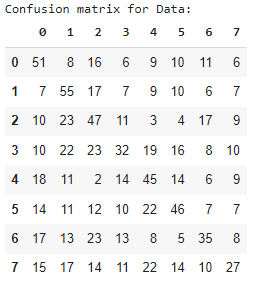

**Analysis**:
Label Order from 0 to 7:  ['frozen' 'hakuna' 'mamma' 'panther' 'potter' 'rain' 'showman' 'starwars']

The Validation accuracy for Extra Tree Classifier model has been taken as an example for the analysis that the problem solution was intended. 

From the Confusion Matrix, it can be deduced that with the feature extracted for the .wav;

* Classes mamma and showman are difficult to predict among each other.

|mamma(2)|showman(6)|
|--|--|
|47|17|
|23|35|

* Another example could be classes panther and potter are difficult to predict among each other.

|panther(3)|potter(4)|
|--|--|
|32|19|
|14|45|

The model build has to be improved so that it can correctly classify multiple songs without any one-on-one comparison and in one iteration. With atleast accuracy of 0.70-0.80 the confusion matrix can provide a better analaysis on the problem selected.


**Improvement**:
* Multiple variation of model can be build with different setting for param_grid.
* Domain knowledge would be required to understand the exact feature to be extracted for signal processing in the first place.
* A framework can be implemented that can test about 10+ classifiers with multple parameter settings.

# 10. Appendix

Following extra steps were taken:
* Label classification: the whole dataset 8 songs of hum and whistle were also tested to get the label classification. For future implementation the Label_Error_Analysis.txt file generated would help in analysing the human error.
* A bit of reading was done on Signal processing to under how to extract time and frequency feature for a signal.
* Multiple combination of features were tried out in 4. Transformation (code section F) with the scattered plot to choose the best possible set of feature to be used.   
* A attempt to build a neural network that classifies that data was build. A tensor flow was created to take 28 feature data and generated sigmoid value. The model was compiled with loss='categorical_crossentropy' as an classification problem and was fit using 2000 sample data to be fitted and evaluated for epochs=10 times. Below implementation shows the work and would be exploring more on that.

In [94]:
def getClassWeight(target):
  unique, counts = np.unique(target, return_counts=True)
  return dict(zip(unique, counts)) 

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.3, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from sklearn.utils.class_weight import compute_class_weight

embeddingDimention = 100

weight = getClassWeight(y_train)
print(weight)
#compute_class_weight(np.unique(y_all), y_all)
model = Sequential()

#model.add(Dense(45, input_shape = (45,), activation='relu'))
model.add(Dense(28,  input_shape = (28,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(
    X_train,
    y_train,
    batch_size=2000,
    epochs = 10,
    validation_split=0.2,
    shuffle=True,
    class_weight = weight
)
score, accuracy = model.evaluate(X_val, y_val)
print(score, accuracy)

{0: 297, 1: 298, 2: 292, 3: 278, 4: 298, 5: 289, 6: 292, 7: 287}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 28)                812       
                                                                 
 dense_5 (Dense)             (None, 1)                 29        
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 1s 751ms/step - loss: 0.0000e+00 - accuracy: 0.1212 - val_loss: 0.0000e+00 - val_accuracy: 0.1520
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 0.1212 - val_loss: 0.0000e+00 - val_accuracy: 0.1520
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy